### Defining best performance metrics to be used for this type of problem

For the most part I see RMSE for this type of problem utilized in other research. I will be using the same metric to evaluate my models.

### Build an automated process for testing various modelling techniques

In [3]:
# import statements to make code work
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

np.set_printoptions(precision=3, suppress=True)

2.9.1


In [4]:
# importing the data I will be using
path = 'data/AAPL_1980-12-12_2022-08-17.csv'

data = pd.read_csv(path)

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


In [6]:
print(len(data))

10509


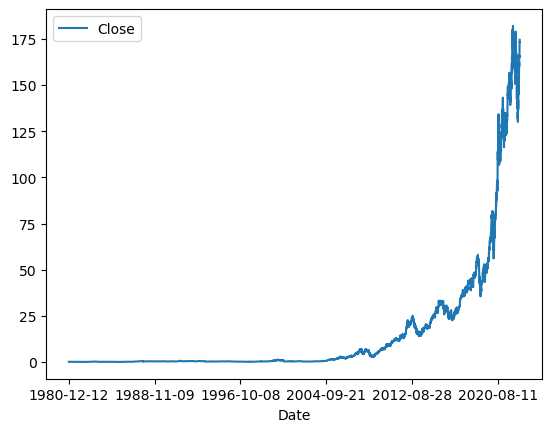

In [7]:
data.plot(x='Date', y='Close')

In [8]:
# Check for nulls
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler(feature_range=(0,1))

In [10]:
split_percent = .8
split_idx = int(split_percent * len(data))

close_prices = data[['Close']]
values = normalizer.fit_transform(close_prices.values)


train_data = values[:split_idx]
X_train = []
y_train = []

lbr = 63 # days in a financial quarter
for i in range(lbr, len(train_data)):
    X_train.append(train_data[i-lbr:i,0])
    y_train.append(train_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # transform to 3 dims

In [11]:
# now for test set
test_data = values[split_idx - lbr:]

X_test = []
y_test = values[split_idx:]

for i in range(lbr, len(test_data)):
    X_test.append(test_data[i-lbr:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [12]:
# setting up the model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 63, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [13]:
# training the model
model.compile(optimizer='adam', loss='mean_absolute_error')
history = model.fit(X_train, y_train, batch_size=10, epochs=10, validation_split=.2)

Epoch 1/10
668/668 [==============================] - 11s 10ms/step - loss: 0.0016 - val_loss: 0.0288
Epoch 2/10
668/668 [==============================] - 6s 9ms/step - loss: 6.1518e-04 - val_loss: 0.0395
Epoch 3/10
668/668 [==============================] - 6s 9ms/step - loss: 4.8877e-04 - val_loss: 0.0110
Epoch 4/10
668/668 [==============================] - 6s 9ms/step - loss: 4.1536e-04 - val_loss: 0.0223
Epoch 5/10
668/668 [==============================] - 6s 9ms/step - loss: 4.2053e-04 - val_loss: 0.0114
Epoch 6/10
668/668 [==============================] - 6s 9ms/step - loss: 3.7665e-04 - val_loss: 0.0141
Epoch 7/10
668/668 [==============================] - 6s 9ms/step - loss: 3.5103e-04 - val_loss: 0.0145
Epoch 8/10
668/668 [==============================] - 6s 9ms/step - loss: 2.9569e-04 - val_loss: 0.0096
Epoch 9/10
668/668 [==============================] - 6s 9ms/step - loss: 3.3454e-04 - val_loss: 0.0069
Epoch 10/10
668/668 [==============================] - 6s 9ms/step

In [14]:
predictions = model.predict(X_test)
predictions = normalizer.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

66/66 [==============================] - 1s 4ms/step


77.26225228209307

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


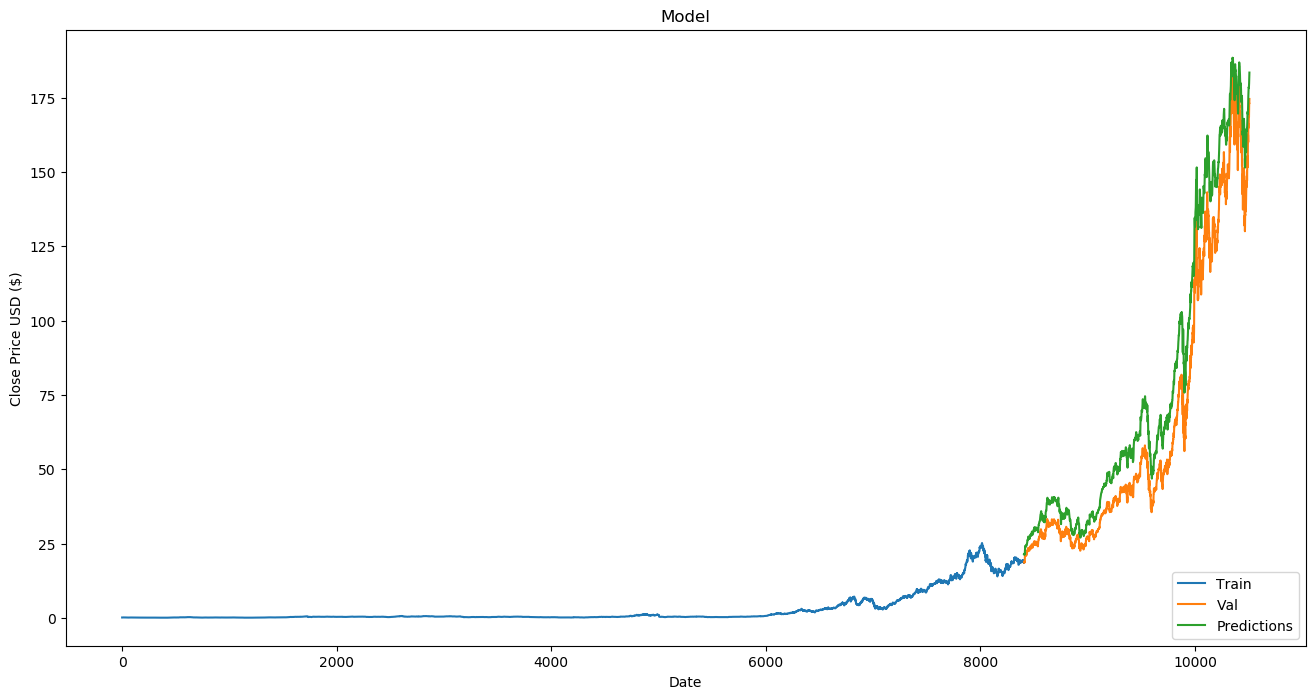

In [15]:
my_data = data.filter(['Close'])
train = my_data[:split_idx]
validation = my_data[split_idx:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [16]:
# creating an automated visualization tool
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

from sklearn.model_selection import GridSearchCV
# creating automated testing for hyper paramaters
def get_best_model(model, params, X_train, y_train):
    clf = GridSearchCV(estimator=model, param_grid=params)
    clf.fit(X_train, y_train)
    print("BEST PARAMS", clf.best_params_)
    best = clf.best_estimator_
    return best

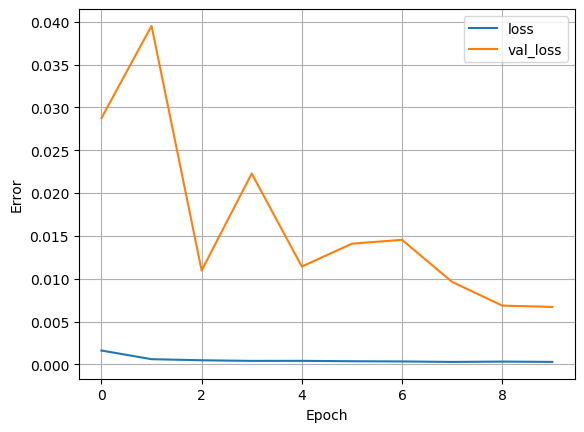

In [17]:
plot_loss(history)

### Model Evaluation Using SMAPE

In [18]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_pred) * 200 / (np.abs(y_pred) / np.abs(y_true))))

## Trying out ARIMA Modelling techniques

In [19]:
# Loading the data
df = pd.read_csv(path)

In [20]:
print(df.shape)
print(df.columns)

(10509, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [21]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [22]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


In [23]:
df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1980-12-12,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1980-12-15,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
1980-12-16,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
1980-12-17,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
1980-12-18,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


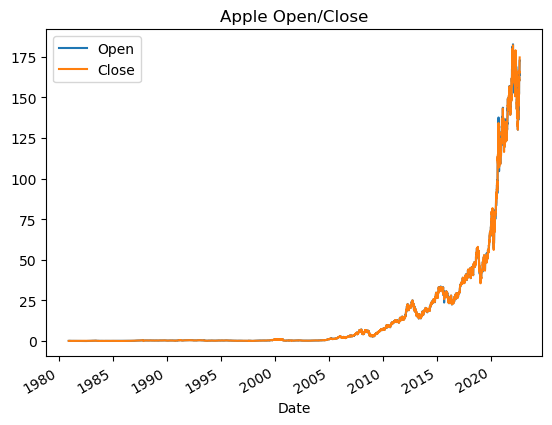

In [24]:
# Visualizing some of the data
df[['Open', 'Close']].plot()
plt.title('Apple Open/Close');

#### Builgin train and test sets

In [33]:
train_data, test_data = df.iloc[:int(len(df)*.8), :], df.iloc[int(len(df) * .8):, :]

### Visualizing Auto-correlation

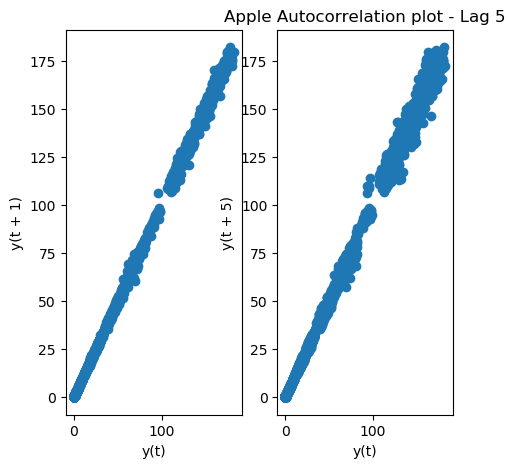

In [32]:
from pandas.plotting import lag_plot

fig, ax = plt.subplots(1, 2, figsize=(5,5))

lag_plot(df['Close'], lag=1, ax=ax[0])
plt.title('Apple Autocorrelation plot - Lag 1')

lag_plot(df['Close'], lag=5, ax=ax[1])
plt.title('Apple Autocorrelation plot - Lag 5');

#### Check the stationarity

In [34]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_data['Close'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                    0.766344
p-value                           0.991073
#Lags Used                       37.000000
Number of Observations Used    8369.000000
Critical Value (1%)              -3.431132
Critical Value (5%)              -2.861885
Critical Value (10%)             -2.566954
dtype: float64

p-value > .05, we need to transform our data

#### First order differencing on the training data

In [35]:
train_diff = train_data['Close'].diff()
train_diff = train_diff.dropna()

In [37]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.348178e+01
p-value                        3.230757e-25
#Lags Used                     3.700000e+01
Number of Observations Used    8.368000e+03
Critical Value (1%)           -3.431132e+00
Critical Value (5%)           -2.861885e+00
Critical Value (10%)          -2.566954e+00
dtype: float64

Great p-value

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


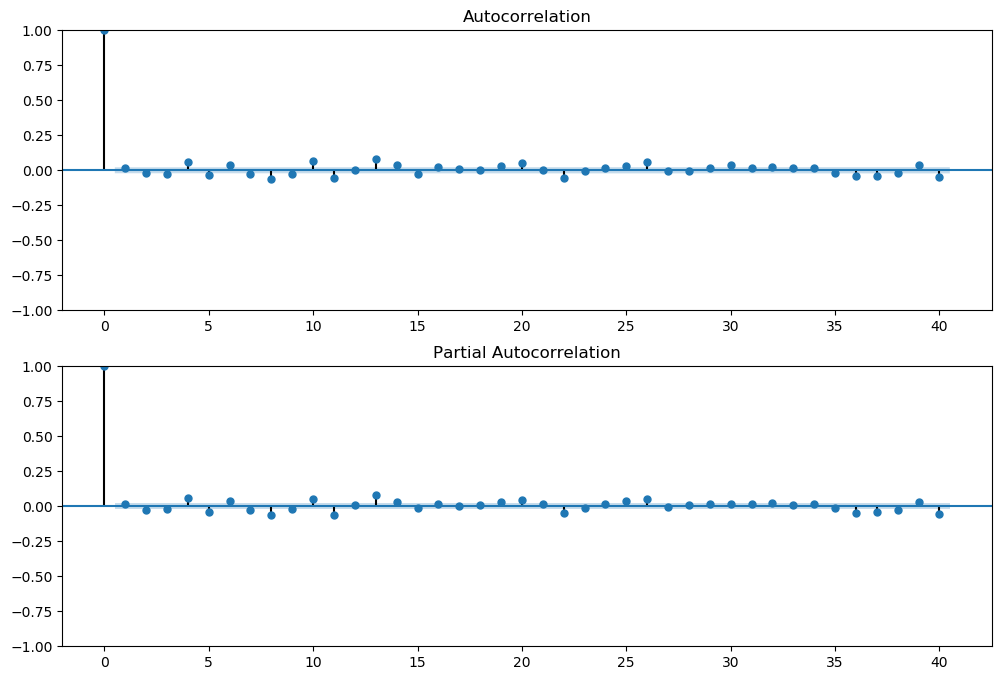

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# more autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_diff, ax=ax[0]);
plot_pacf(train_diff, ax=ax[1]);

#### Determining p, d, q

d = 1

p = (4, 5, 8)

q = 0

In [39]:
# creating the test diff
test_diff = test_data['Close'].diff()
test_diff = test_diff.dropna()

## Train and Forecast using ARIMA Model

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [44]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    # call the ARIMA Method with history and params
    model = ARIMA(history, order=(4,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit()  # fit the model

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=-0.07788993300513561, Expected=-0.1328582763671875
Test Series Point: 100	Predicted=-0.1228533270464891, Expected=-0.15250015258789062
Test Series Point: 200	Predicted=0.3436224893547626, Expected=-0.4349994659423828
Test Series Point: 300	Predicted=-0.020860591257630262, Expected=0.2700004577636719
Test Series Point: 400	Predicted=-0.2665922703120875, Expected=-0.845001220703125
Test Series Point: 500	Predicted=-0.07022741934500976, Expected=0.08999824523925781
Test Series Point: 600	Predicted=-0.14466753894129353, Expected=0.02499961853027699
Test Series Point: 700	Predicted=-0.004033911595243498, Expected=0.4774990081787074
Test Series Point: 800	Predicted=-0.32627585101953416, Expected=1.0174980163574219
Test Series Point: 900	Predicted=0.24811195237845637, Expected=0.3575019836425781
Test Series Point: 1000	Predicted=0.18273439114293488, Expected=0.2975006103515625
Test Series Point: 1100	Predicted=-0.059823787348804, Expected=0.44499969482421875
Tes

#### Reverse the transformations

In [45]:
reverse_test_diff = np.r_[test_data['Close'].iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_data['Close'].iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((2102,), (2102,))

In [46]:
# Evaluate model performance
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 6.424
Symmetric Mean absolute percentage error: 0.000


### Visualizing our results

In [47]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_data['Close'].index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_data['Close'].index

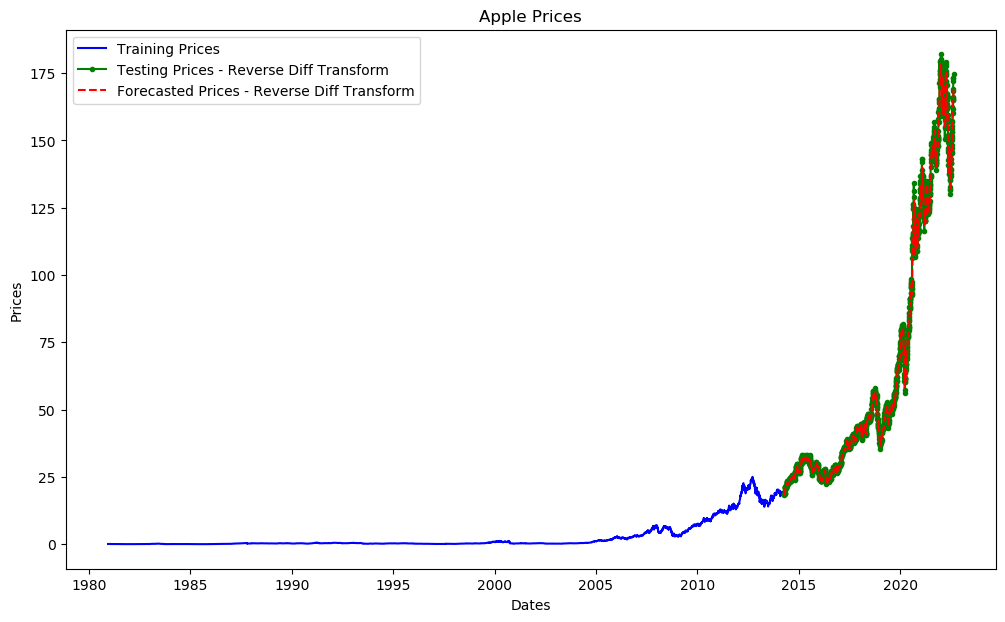

In [48]:
plt.figure(figsize=(12,7))
plt.title('Apple Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Close'], color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

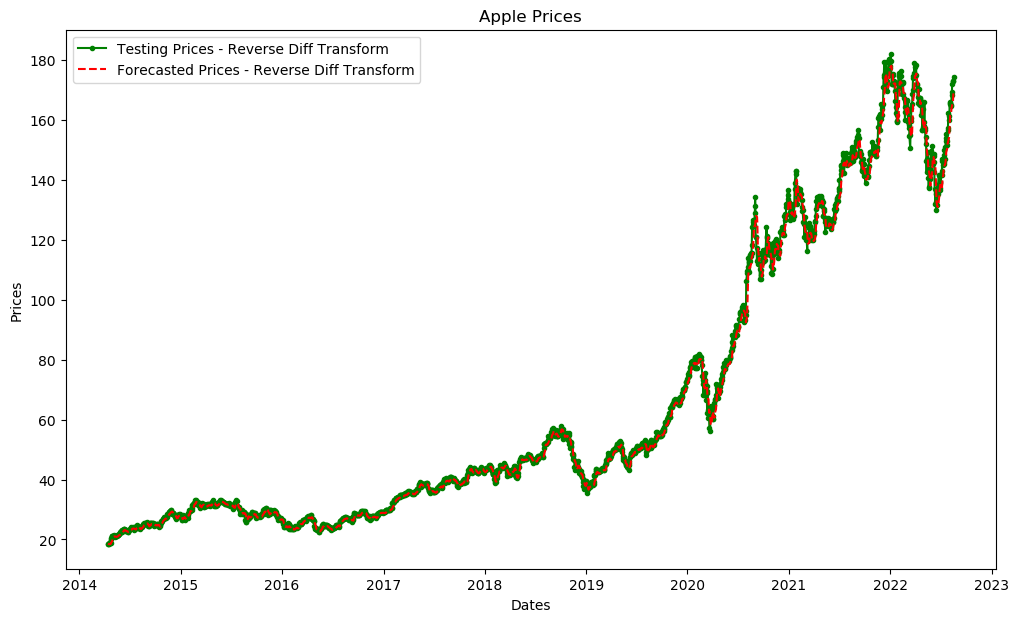

In [49]:
# Closer look at the test area
plt.figure(figsize=(12, 7))
plt.title('Apple Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend(loc='best');

### Where to go from here

1. try to use a different training method specific to multiple time series
2. when testing use the window-sized evaluations instead of single day evals, similar to that lesson